## Import all required libraries

In [1]:
import sys
import os
import tensorflow as tf
import numpy as np
import tensorflow_probability as tfp

# Manually making sure the numpy random seeds are "the same" on all devices
np.random.seed(1234)
tf.random.set_seed(1234)

import scipy.io
import time
from datetime import datetime
from pyDOE import lhs
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.interpolate import griddata
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Function to load dataset and bring to proper form for training

In [2]:
def prep_data(N_u=None, N_f=None):
    
    # Loading the dataset from .npy files
    t = np.load('time.npy')
    conc = np.load('Conc.npy')
    x = np.arange(1,129)
    y = np.arange(1,129)
    
    # Creating a meshgrid of all possible tuples of x, y, t
    xv,yv,tv = np.meshgrid(x,y,t,indexing='ij')
        
    # Preparing the inputs x , y and t (meshed as xv, yv and tv) for predictions in one single array, as inp_star
    inp_star = np.hstack((xv.flatten()[:,None], yv.flatten()[:,None],tv.flatten()[:,None]))
    inp_star = inp_star[np.argsort(inp_star[:,2],kind='mergesort')]
    inp_star[:,[0,1]] = inp_star[:,[1,0]]

    # Preparing the testing conc_star
    conc_star = conc.flatten('F')[:,None]
    
    idx = np.random.choice(inp_star.shape[0], N_u, replace=False)
    inp_train = inp_star[idx,:]
    conc_train = conc_star[idx,:]
    
    # For the case when N_f is not given as input
    if N_f == None:
        lb = X_star.min(axis=0)
        ub = X_star.max(axis=0) 
        return x, t, X, T, Exact_u, inp_star, conc_star, inp_train, conc_train, ub, lb

    # Domain bounds (lowerbounds upperbounds) [x, y, t], which are here ([1, 1, 0] and [128, 128, 5000])
    lb = inp_star.min(axis=0)
    ub = inp_star.max(axis=0)
    # Getting the initial conditions (t=0)
    initial_cond = inp_star[0:128*128,:]
    conc_initial_cond = conc[:,:,0]
    conc_initial_cond = conc_initial_cond.flatten('F')[:,None]
    # Getting the all boundary conditions
    top_bound = inp_star[inp_star[:,0]==1]
    bottom_bound = inp_star[inp_star[:,0]==128]
    left_bound = inp_star[inp_star[:,1]==1]
    right_bound = inp_star[inp_star[:,1]==128]
    boundary_ind = np.vstack((top_bound,bottom_bound,left_bound,right_bound))
    
    conc_boundary = []
    for i in np.arange(boundary_ind.shape[0]):
        conc_boundary.append(conc[boundary_ind[i,0]-1,boundary_ind[i,1]-1,boundary_ind[i,2]])
    conc_boundary = np.asarray(conc_boundary)
    conc_boundary = conc_boundary.flatten('F')[:,None]
    
    # Stacking them in multidimensional tensors for training (inp_train)
    inp_train = np.vstack([initial_cond,boundary_ind])
    conc_train = np.vstack([conc_initial_cond, conc_boundary])

    # Generating the x, y and t collocation points for f, with each having a N_f size
    # We pointwise add and multiply to spread the LHS over the 3D domain
    inp_f_train = lb + (ub-lb)*lhs(3, N_f)

    # Generating a uniform random sample from ints between 0, and the size of inp_train, of size N_u (initial data size) and without replacement (unique)
    idx = np.random.choice(inp_train.shape[0], N_u, replace=False)
    # Getting the corresponding inp_train (which is now scarce boundary and initial coordinates)
    inp_train = inp_train[idx,:]
    # Getting the corresponding conc_train
    conc_train = conc_train[idx,:]

    return x, y, t, xv, tv, yv, conc, inp_star, conc_star, inp_train, conc_train, inp_f_train, ub, lb


## Logger class implemented for error and loss analysis

In [3]:
class Logger(object):
    def __init__(self, frequency=10):
        print("TensorFlow version: {}".format(tf.__version__))
        print("Eager execution: {}".format(tf.executing_eagerly()))
        print("GPU-accerelated: {}".format(tf.test.is_gpu_available()))

        self.start_time = time.time()
        self.frequency = frequency

    def __get_elapsed(self):
        return datetime.fromtimestamp(time.time() - self.start_time).strftime("%M:%S")

    def __get_error_u(self):
        return self.error_fn()

    def set_error_fn(self, error_fn):
        self.error_fn = error_fn
  
    def log_train_start(self, model):
        print("\nTraining started")
        print("================")
        self.model = model
        print(self.model.summary())

    def log_train_epoch(self, epoch, loss, custom="", is_iter=False):
        if epoch % self.frequency == 0:
            print(f"{'nt_epoch' if is_iter else 'tf_epoch'} = {epoch:6d}  elapsed = {self.__get_elapsed()}  loss = {loss:.4e}  error = {self.__get_error_u():.4e}  " + custom)

    def log_train_opt(self, name):
        # print(f"tf_epoch =      0  elapsed = 00:00  loss = 2.7391e-01  error = 9.0843e-01")
        print(f"—— Starting {name} optimization ——")

    def log_train_end(self, epoch, custom=""):
        print("==================")
        print(f"Training finished (epoch {epoch}): duration = {self.__get_elapsed()}  error = {self.__get_error_u():.4e}  " + custom)


## Additional Functional dependencies like L-BFGS etc

In [4]:
import tensorflow as tf
import numpy as np
import time

# Time tracking functions
global_time_list = []
global_last_time = 0
def reset_time():
    global global_time_list, global_last_time
    global_time_list = []
    global_last_time = time.perf_counter()
    
def record_time():
    global global_last_time, global_time_list
    new_time = time.perf_counter()
    global_time_list.append(new_time - global_last_time)
    global_last_time = time.perf_counter()
    #print("step: %.2f"%(global_time_list[-1]*1000))

def last_time():
    """Returns last interval records in millis."""
    global global_last_time, global_time_list
    if global_time_list:
        return 1000 * global_time_list[-1]
    else:
        return 0

def dot(a, b):
    """Dot product function since TensorFlow doesn't have one."""
    return tf.reduce_sum(a*b)

def verbose_func(s):
    print(s)

final_loss = None
times = []
def lbfgs(opfunc, x, config, state, do_verbose, log_fn):
    """port of lbfgs.lua, using TensorFlow eager mode."""

    if config.maxIter == 0:
        return

    global final_loss, times

    maxIter = config.maxIter
    maxEval = config.maxEval or maxIter*1.25
    tolFun = config.tolFun or 1e-5
    tolX = config.tolX or 1e-19
    nCorrection = config.nCorrection or 100
    lineSearch = config.lineSearch
    lineSearchOpts = config.lineSearchOptions
    learningRate = config.learningRate or 1
    isverbose = config.verbose or False

    # verbose function
    if isverbose:
        verbose = verbose_func
    else:
        verbose = lambda x: None

    # evaluate initial f(x) and df/dx
    f, g = opfunc(x)

    f_hist = [f]
    currentFuncEval = 1
    state.funcEval = state.funcEval + 1
    p = g.shape[0]

    # check optimality of initial point
    tmp1 = tf.abs(g)
    if tf.reduce_sum(tmp1) <= tolFun:
        verbose("optimality condition below tolFun")
        return x, f_hist

    # optimize for a max of maxIter iterations
    nIter = 0
    times = []
    while nIter < maxIter:
        start_time = time.time()

        # keep track of nb of iterations
        nIter = nIter + 1
        state.nIter = state.nIter + 1

    ############################################################
    ## compute gradient descent direction
    ############################################################
        if state.nIter == 1:
            d = -g
            old_dirs = []
            old_stps = []
            Hdiag = 1
        else:
            # do lbfgs update (update memory)
            y = g - g_old
            s = d*t
            ys = dot(y, s)
      
            if ys > 1e-10:
                # updating memory
                if len(old_dirs) == nCorrection:
                    # shift history by one (limited-memory)
                    del old_dirs[0]
                    del old_stps[0]

                # store new direction/step
                old_dirs.append(s)
                old_stps.append(y)

                # update scale of initial Hessian approximation
                Hdiag = ys/dot(y, y)

            # compute the approximate (L-BFGS) inverse Hessian 
            # multiplied by the gradient
            k = len(old_dirs)

            # need to be accessed element-by-element, so don't re-type tensor:
            ro = [0]*nCorrection
            for i in range(k):
                ro[i] = 1/dot(old_stps[i], old_dirs[i])
        

            # iteration in L-BFGS loop collapsed to use just one buffer
            # need to be accessed element-by-element, so don't re-type tensor:
            al = [0]*nCorrection

            q = -g
            for i in range(k-1, -1, -1):
                al[i] = dot(old_dirs[i], q) * ro[i]
                q = q - al[i]*old_stps[i]

            # multiply by initial Hessian
            r = q*Hdiag
            for i in range(k):
                be_i = dot(old_stps[i], r) * ro[i]
                r += (al[i]-be_i)*old_dirs[i]
        
            d = r
        # final direction is in r/d (same object)

        g_old = g
        f_old = f
    
        ############################################################
        ## compute step length
        ############################################################
        # directional derivative
        gtd = dot(g, d)

        # check that progress can be made along that direction
        if gtd > -tolX:
            verbose("Can not make progress along direction.")
            break

        # reset initial guess for step size
        if state.nIter == 1:
            tmp1 = tf.abs(g)
            t = min(1, 1/tf.reduce_sum(tmp1))
        else:
            t = learningRate


        # optional line search: user function
        lsFuncEval = 0
        if lineSearch and isinstance(lineSearch) == types.FunctionType:
            # perform line search, using user function
            f,g,x,t,lsFuncEval = lineSearch(opfunc,x,t,d,f,g,gtd,lineSearchOpts)
            f_hist.append(f)
        else:
            # no line search, simply move with fixed-step
            x += t*d
      
            if nIter != maxIter:
                # re-evaluate function only if not in last iteration
                # the reason we do this: in a stochastic setting,
                # no use to re-evaluate that function here
                f, g = opfunc(x)
                lsFuncEval = 1
                f_hist.append(f)


        # update func eval
        currentFuncEval = currentFuncEval + lsFuncEval
        state.funcEval = state.funcEval + lsFuncEval

        ############################################################
        ## check conditions
        ############################################################
        if nIter == maxIter:
            break

        if currentFuncEval >= maxEval:
            # max nb of function evals
            verbose('max nb of function evals')
            break

        tmp1 = tf.abs(g)
        if tf.reduce_sum(tmp1) <=tolFun:
            # check optimality
            verbose('optimality condition below tolFun')
            break
    
        tmp1 = tf.abs(d*t)
        if tf.reduce_sum(tmp1) <= tolX:
            # step size below tolX
            verbose('step size below tolX')
            break

        if tf.abs(f-f_old) < tolX:
            # function value changing less than tolX
            verbose('function value changing less than tolX'+str(tf.abs(f-f_old)))
            break

        if do_verbose:
            log_fn(nIter, f.numpy(), True)
            #print("Step %3d loss %6.5f msec %6.3f"%(nIter, f.numpy(), last_time()))
            record_time()
            times.append(last_time())

        if nIter == maxIter - 1:
            final_loss = f.numpy()

    # save state
    state.old_dirs = old_dirs
    state.old_stps = old_stps
    state.Hdiag = Hdiag
    state.g_old = g_old
    state.f_old = f_old
    state.t = t
    state.d = d

    return x, f_hist, currentFuncEval

# dummy/Struct gives Lua-like struct object with 0 defaults
class dummy(object):
    pass

class Struct(dummy):
    def __getattribute__(self, key):
        if key == '__dict__':
            return super(dummy, self).__getattribute__('__dict__')
        return self.__dict__.get(key, 0)

# PINN Architecture defined for 2-D Cahn-Hilliard equation

## Formulation

### 1. Order parameter

An order parameter  c  is defined as the concentration of B atom. The unit of  c  is defined as atomic fraction in this code.

### 2. Total free energy

The total Gibbs free energy of the system is defined by

$ G = \int_{V} \left( g_{chem}(u) + g_{grad}(\nabla u) \right) dV $
 
where  $g_{chem}$  and  $g_{grad}$ are the chemical free energy and the gradient energy densities, respectively. The chemical free energy density is formulated based on the regular solution approximation as:

$ g_{chem} = RT\left[ u\ln u + (1-u)\ln(1-u)\right] + Lu(1-u) $
 
where  $L$  is the atomic interaction parameter. The gradient energy density is expressed by:

$ g_{grad} = \frac{a_{c}}{2} \left| \nabla u \right|^{2} $
 
where  $a_{c}$  is the gradient energy coefficient. In this model,  $a_{c}$  is not related to any physical values.

### 3. Time evolution equation

The time evolution of the order parameter  $u$  is given by assuming that the total free energy of the system  $G$  decreases monotonically with time. For the conserved order parameter, the time evolution equation is derived from the Cahn-Hilliard equation given as:

$ \frac{\partial u}{\partial t} = \nabla \cdot \left( M_{c} \nabla \frac{\delta G}{\delta u} \right) =  \nabla \cdot \left( M_{c} \nabla \mu \right) $
 
where  $\mu$  is the diffusion potential of B atom. According to the total Gibbs free energy,  $\mu$  is expressed by:

$ \mu = \frac{\delta G}{\delta u} = RT\left[ \ln u - \ln (1-u) \right] + L(1-2u) - a_{c} \nabla^{2}u $
 
Here, remind that the functional derivative of $G$  is given by the Euler-Lagrange equation:

$ \frac{\delta G}{\delta u}=\frac{\partial g}{\partial u}-\nabla\cdot\frac{\partial g}{\partial (\nabla u)} $
 
$M$  is the diffusion mobility of B atom which is assumed to be given by:

$ M_{c} = \left[ \frac{D_{A}}{RT}u + \frac{D_{B}}{RT}(1-u)\right]u(1-u) = \frac{D_{A}}{RT}\left[ u + \frac{D_{B}}{D_{A}}(1-u)\right]u(1-u) $
 
Here,  $D_{A}$  and  $D_{B}$  are the diffusion coefficients of A and B atoms, respectively.

Since the diffusion mobility  $M_{c}$  depends on  $u$ , in two-dimensional space, the time evolution equation can be written as:

$ \frac{\partial u}{\partial t} =  \nabla \cdot \left( M_{c} \nabla \mu \right) = M_{c} \left(\frac{\partial^{2}\mu}{\partial x^{2}} +  \frac{\partial^{2}\mu}{\partial y^{2}}\right) + \frac{\partial M_{c}}{\partial u} \left( \frac{\partial u}{\partial x}\frac{\partial \mu}{\partial x} +  \frac{\partial u}{\partial y}\frac{\partial \mu}{\partial y} \right) $
 
where the derivative of  $M_{c}$   with respect to  $ u $  is given by:

$ \frac{\partial M_{c}}{\partial u} = \frac{D_{A}}{RT}\left[ \left(1-\frac{D_{B}}{D_{A}}\right)u(1-u) + \left(u+ \frac{D_{B}}{D_{A}}(1-u)\right)(1-2u) \right] $

In [5]:
class PhysicsInformedNN(object):
    def __init__(self, layers, optimizer, logger, inp_f, ub, lb, R, temp, L_a, a_c, D_a, D_b):
        # Descriptive Keras model [3, 20, …, 20, 1]
        self.u_model = tf.keras.Sequential()
        self.u_model.add(tf.keras.layers.InputLayer(input_shape=(layers[0],)))
        self.u_model.add(tf.keras.layers.Lambda(lambda X: 2*(X - lb)/(ub - lb) - 1.0))
        for width in layers[1:]:
            if width != 1:
                self.u_model.add(tf.keras.layers.Dense(width, activation=tf.nn.tanh,kernel_initializer='glorot_normal'))
            else:
                self.u_model.add(tf.keras.layers.Dense(width, activation=tf.nn.sigmoid,kernel_initializer='glorot_normal'))

        # Computing the sizes of weights/biases for future decomposition
        self.sizes_w = []
        self.sizes_b = []
        for i, width in enumerate(layers):
            if i != 1:
                self.sizes_w.append(int(width * layers[1]))
                self.sizes_b.append(int(width if i != 0 else layers[1]))

        self.R = R
        self.temp = temp
        self.D_a = D_a
        self.D_b = D_b
        self.a_c = a_c
        self.L_a = L_a
        self.optimizer = optimizer
        self.logger = logger

        self.dtype = tf.float32

        # Separating the collocation coordinates
        self.x_f = tf.convert_to_tensor(inp_f[:, 0:1], dtype=self.dtype)
        self.y_f = tf.convert_to_tensor(inp_f[:, 1:2], dtype=self.dtype)
        self.t_f = tf.convert_to_tensor(inp_f[:, 2:3], dtype=self.dtype)
    
        # Defining custom loss
    def __loss(self, u, u_pred):
        f_pred = self.f_model()
        return tf.reduce_mean(tf.square(u - u_pred)) + \
            tf.reduce_mean(tf.square(f_pred))

    def __grad(self, X, u):
        with tf.GradientTape() as tape:
            loss_value = self.__loss(u, self.u_model(X))
        return loss_value, tape.gradient(loss_value, self.__wrap_training_variables())

    def __wrap_training_variables(self):
        var = self.u_model.trainable_variables
        return var

    # The actual PINN
    def f_model(self):
        R = self.R
        T = self.temp
        D_a = self.D_a
        D_b = self.D_b
        a_c = self.a_c
        L = self.L_a
        # Using the new GradientTape paradigm of TF2.0,
        # which keeps track of operations to get the gradient at runtime
        with tf.GradientTape(persistent=True) as tape:
            # Watching the three inputs we’ll need later, x, y and t
            tape.watch(self.x_f)
            tape.watch(self.y_f)
            tape.watch(self.t_f)
            tape.watch(self.t_f)
            # Packing together the inputs
            X_f = tf.stack([self.x_f[:,0], self.y_f[:,0],self.t_f[:,0]], axis=1)
            # Getting the prediction
            u = self.u_model(X_f)
            np.where(u!=0,u,0.001)
            # Deriving INSIDE the tape (since we’ll need the x derivative of this later, u_xx)
            u_x = tape.gradient(u, self.x_f)
            u_y = tape.gradient(u, self.y_f)
            u_xx = tape.gradient(u_x, self.x_f)
            u_yy = tape.gradient(u_y, self.y_f)
            mu = (R*T)*(np.log(u/(1-u))) + (L*(1-2*u)) - (a_c*(u_xx+u_yy))
            mu_x = tape.gradient(mu, self.x_f)
            mu_y = tape.gradient(mu, self.y_f)
            M_c = (D_a/R/T)*(u + (D_b/D_a)*(1-u))*(u*(1-u))
            
            #tape.watch(mu)
        # Getting the other derivatives
        Mc_u = tape.gradient(M_c, u)
        #Mc_u = (D_a/R/T)*((1-(D_b/D_a))*u*(1-u) + (u + (D_b/D_a)*(1-u))(1-2*u))
        u_t = tape.gradient(u, self.t_f)
        mu_xx = tape.gradient(mu_x, self.x_f)
        mu_yy = tape.gradient(mu_y, self.y_f)

        # Letting the tape go
        del tape
        
        f_err = u_t - M_c*(mu_xx+mu_yy) + Mc_u*((u_x*mu_x)+(u_y*mu_y))
        
        # Buidling the PINNs
        return f_err

    def get_weights(self):
        w = []
        for layer in self.u_model.layers[1:]:
            weights_biases = layer.get_weights()
            weights = weights_biases[0].flatten()
            biases = weights_biases[1]
            w.extend(weights)
            w.extend(biases)
        return tf.convert_to_tensor(w, dtype=self.dtype)

    def set_weights(self, w):
        for i, layer in enumerate(self.u_model.layers[1:]):
            start_weights = sum(self.sizes_w[:i]) + sum(self.sizes_b[:i])
            end_weights = sum(self.sizes_w[:i+1]) + sum(self.sizes_b[:i])
            weights = w[start_weights:end_weights]
            w_div = int(self.sizes_w[i] / self.sizes_b[i])
            weights = tf.reshape(weights, [w_div, self.sizes_b[i]])
            biases = w[end_weights:end_weights + self.sizes_b[i]]
            weights_biases = [weights, biases]
            layer.set_weights(weights_biases)

    def summary(self):
        return self.u_model.summary()

    # The training function
    def fit(self, X_u, u, tf_epochs=5000, nt_config=Struct()):
        self.logger.log_train_start(self)

        # Creating the tensors
        X_u = tf.convert_to_tensor(X_u, dtype=self.dtype)
        u = tf.convert_to_tensor(u, dtype=self.dtype)

        self.logger.log_train_opt("Adam")
        for epoch in range(tf_epochs):
            # Optimization step
            loss_value, grads = self.__grad(X_u, u)
            self.optimizer.apply_gradients(zip(grads, self.__wrap_training_variables()))
            self.logger.log_train_epoch(epoch, loss_value)
    
        self.logger.log_train_opt("LBFGS")
        def loss_and_flat_grad(w):
            with tf.GradientTape() as tape:
                self.set_weights(w)
                loss_value = self.__loss(u, self.u_model(X_u))
            grad = tape.gradient(loss_value, self.u_model.trainable_variables)
            grad_flat = []
            for g in grad:
                grad_flat.append(tf.reshape(g, [-1]))
            grad_flat =  tf.concat(grad_flat, 0)
            return loss_value, grad_flat
        # tfp.optimizer.lbfgs_minimize(
        #   loss_and_flat_grad,
        #   initial_position=self.get_weights(),
        #   num_correction_pairs=nt_config.nCorrection,
        #   max_iterations=nt_config.maxIter,
        #   f_relative_tolerance=nt_config.tolFun,
        #   tolerance=nt_config.tolFun,
        #   parallel_iterations=6)
        lbfgs(loss_and_flat_grad,self.get_weights(),nt_config, Struct(), True, lambda epoch, loss, is_iter:self.logger.log_train_epoch(epoch, loss, "", is_iter))

        self.logger.log_train_end(tf_epochs + nt_config.maxIter)

    def predict(self, X_star):
        u_star = self.u_model(X_star)
        f_star = self.f_model()
        return u_star, f_star

## Intializing hyperparameters and Cahn-Hilliard parameters 

In [6]:
# Data size on the solution u
N_u = 25000
# Collocation points size, where we’ll check for f = 0
N_f = 10000
# DeepNN topology (2-sized input [x t], 8 hidden layer of 20-width, 1-sized output [u]
layers = [3, 20, 20, 20, 20, 20, 20, 20, 20, 1]
# Setting up the TF SGD-based optimizer (set tf_epochs=0 to cancel it)
tf_epochs = 1000
tf_optimizer = tf.keras.optimizers.Adam(
  learning_rate=0.1,
  beta_1=0.99,
  epsilon=1e-1)
# Setting up the quasi-newton LBGFS optimizer (set nt_epochs=0 to cancel it)
nt_epochs = 2000
nt_config = Struct()
nt_config.learningRate = 0.8
nt_config.maxIter = nt_epochs
nt_config.nCorrection = 50
nt_config.tolFun = 1.0 * np.finfo(float).eps

R = 8.314 # gas constant
temp = 673 # temperature [K]
L_a = 20000.-9.*temp # Atom intaraction constant [J/mol]
a_c = 3.0e-14 # gradient coefficient [Jm2/mol]
D_a = 1.0e-04*np.exp(-300000.0/R/temp) # diffusion coefficient of A atom [m2/s]
D_b = 2.0e-05*np.exp(-300000.0/R/temp) # diffusion coefficient of B atom [m2/s]

## Running prep_data() to formulate dataset for training

In [7]:
x, y, t, xv, tv, yv, conc, inp_star, conc_star, inp_train, conc_train, inp_f_train, ub, lb = prep_data(N_u, N_f)

In [8]:
# Creating the model and training
logger = Logger(frequency=10)
pinn = PhysicsInformedNN(layers, tf_optimizer, logger, inp_f_train, ub, lb,  R, temp, L_a, a_c, D_a, D_b)
def error():
    u_pred, _ = pinn.predict(inp_star[0:100000,:])
    return np.linalg.norm(conc_star[0:100000,:] - u_pred, 2) / np.linalg.norm(conc_star[0:100000,:], 2)
logger.set_error_fn(error)
pinn.fit(inp_train, conc_train, tf_epochs, nt_config)

TensorFlow version: 2.0.0
Eager execution: True
GPU-accerelated: True

Training started
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 3)                 0         
_________________________________________________________________
dense (Dense)                (None, 20)                80        
_________________________________________________________________
dense_1 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_3 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_4 (Dense)              (None, 20)                420       
__________________________________

tf_epoch =    440  elapsed = 08:05  loss = 1.4670e-02  error = 7.1590e-02  
tf_epoch =    450  elapsed = 08:15  loss = 1.4671e-02  error = 7.2013e-02  
tf_epoch =    460  elapsed = 08:26  loss = 1.4670e-02  error = 7.2307e-02  
tf_epoch =    470  elapsed = 08:37  loss = 1.4666e-02  error = 7.2444e-02  
tf_epoch =    480  elapsed = 08:47  loss = 1.4662e-02  error = 7.2427e-02  
tf_epoch =    490  elapsed = 08:59  loss = 1.4658e-02  error = 7.2266e-02  
tf_epoch =    500  elapsed = 09:10  loss = 1.4655e-02  error = 7.1990e-02  
tf_epoch =    510  elapsed = 09:20  loss = 1.4653e-02  error = 7.1655e-02  
tf_epoch =    520  elapsed = 09:31  loss = 1.4652e-02  error = 7.1335e-02  
tf_epoch =    530  elapsed = 09:42  loss = 1.4651e-02  error = 7.1095e-02  
tf_epoch =    540  elapsed = 09:53  loss = 1.4649e-02  error = 7.0981e-02  
tf_epoch =    550  elapsed = 10:04  loss = 1.4645e-02  error = 7.1026e-02  
tf_epoch =    560  elapsed = 10:14  loss = 1.4640e-02  error = 7.1235e-02  
tf_epoch =  

nt_epoch =    530  elapsed = 28:12  loss = 7.3280e-03  error = 9.1639e-02  
nt_epoch =    540  elapsed = 28:25  loss = 7.1811e-03  error = 9.4063e-02  
nt_epoch =    550  elapsed = 28:37  loss = 7.0860e-03  error = 9.1112e-02  
nt_epoch =    560  elapsed = 28:50  loss = 7.0086e-03  error = 8.9338e-02  
nt_epoch =    570  elapsed = 29:01  loss = 6.9018e-03  error = 9.0255e-02  
nt_epoch =    580  elapsed = 29:12  loss = 6.8289e-03  error = 9.0042e-02  
nt_epoch =    590  elapsed = 29:23  loss = 6.7557e-03  error = 9.0152e-02  
nt_epoch =    600  elapsed = 29:35  loss = 6.6791e-03  error = 8.9018e-02  
nt_epoch =    610  elapsed = 29:47  loss = 6.6237e-03  error = 8.9785e-02  
nt_epoch =    620  elapsed = 29:59  loss = 6.5601e-03  error = 9.2378e-02  
nt_epoch =    630  elapsed = 30:11  loss = 6.4826e-03  error = 9.1748e-02  
nt_epoch =    640  elapsed = 30:22  loss = 6.3998e-03  error = 9.0980e-02  
nt_epoch =    650  elapsed = 30:34  loss = 6.3069e-03  error = 9.2996e-02  
nt_epoch =  

nt_epoch =   1610  elapsed = 48:19  loss = 2.9667e-03  error = 1.0453e-01  
nt_epoch =   1620  elapsed = 48:30  loss = 2.9490e-03  error = 1.0256e-01  
nt_epoch =   1630  elapsed = 48:41  loss = 2.9294e-03  error = 1.0217e-01  
nt_epoch =   1640  elapsed = 48:52  loss = 2.9089e-03  error = 1.0120e-01  
nt_epoch =   1650  elapsed = 49:04  loss = 2.8846e-03  error = 1.0089e-01  
nt_epoch =   1660  elapsed = 49:16  loss = 2.8690e-03  error = 1.0014e-01  
nt_epoch =   1670  elapsed = 49:28  loss = 2.8560e-03  error = 9.9121e-02  
nt_epoch =   1680  elapsed = 49:39  loss = 2.8406e-03  error = 9.6660e-02  
nt_epoch =   1690  elapsed = 49:51  loss = 2.8269e-03  error = 9.4850e-02  
nt_epoch =   1700  elapsed = 50:02  loss = 2.8119e-03  error = 9.3626e-02  
nt_epoch =   1710  elapsed = 50:13  loss = 2.7977e-03  error = 9.2826e-02  
nt_epoch =   1720  elapsed = 50:24  loss = 2.7861e-03  error = 9.2934e-02  
nt_epoch =   1730  elapsed = 50:35  loss = 2.7740e-03  error = 9.2989e-02  
nt_epoch =  

In [12]:
u_pred, f_pred = pinn.predict(inp_star[32768000:,:])

In [9]:
inp_star.shape

(32784384, 3)

In [11]:
32784384-(128*128)

32768000

In [ ]:
u_pred, f_pred = pinn.predict(inp_star[0:128*128,:])

In [14]:
u_pred = np.asarray(u_pred)

In [15]:
u_pred = u_pred.reshape((128,128))

In [16]:
u_pred

array([[0.57350284, 0.5685475 , 0.56245184, ..., 0.62742037, 0.7732414 ,
        0.8024825 ],
       [0.5471482 , 0.54328114, 0.53828645, ..., 0.7334618 , 0.8011007 ,
        0.7270435 ],
       [0.51698947, 0.51417625, 0.5103012 , ..., 0.78835833, 0.75742024,
        0.5624922 ],
       ...,
       [0.60846424, 0.7206157 , 0.79283804, ..., 0.5352092 , 0.5336466 ,
        0.5321508 ],
       [0.7444018 , 0.79958695, 0.78786135, ..., 0.5380051 , 0.5363639 ,
        0.534769  ],
       [0.8009851 , 0.7652694 , 0.593369  , ..., 0.5408544 , 0.53918284,
        0.53753453]], dtype=float32)

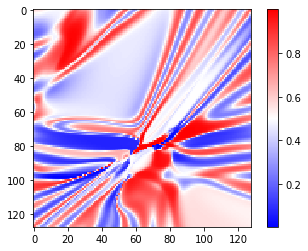

In [17]:
plt.imshow(u_pred,cmap='bwr');
plt.colorbar()
plt.show()

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)